In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Set a seed for reproducibility
np.random.seed(42)

# Define the path to the dataset
data_dir = "diss_dataset/chest_xray/"

# Check directory structure
print("Directory Structure:")
for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"{dirpath}: {len(dirnames)} directories, {len(filenames)} files")

# Define the paths for training, validation, and test sets
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

Directory Structure:
diss_dataset/chest_xray/: 4 directories, 0 files
diss_dataset/chest_xray/chest_xray: 3 directories, 1 files
diss_dataset/chest_xray/chest_xray\test: 2 directories, 1 files
diss_dataset/chest_xray/chest_xray\test\NORMAL: 0 directories, 234 files
diss_dataset/chest_xray/chest_xray\test\PNEUMONIA: 0 directories, 390 files
diss_dataset/chest_xray/chest_xray\train: 2 directories, 1 files
diss_dataset/chest_xray/chest_xray\train\NORMAL: 0 directories, 1342 files
diss_dataset/chest_xray/chest_xray\train\PNEUMONIA: 0 directories, 3876 files
diss_dataset/chest_xray/chest_xray\val: 2 directories, 1 files
diss_dataset/chest_xray/chest_xray\val\NORMAL: 0 directories, 9 files
diss_dataset/chest_xray/chest_xray\val\PNEUMONIA: 0 directories, 9 files
diss_dataset/chest_xray/test: 2 directories, 0 files
diss_dataset/chest_xray/test\NORMAL: 0 directories, 234 files
diss_dataset/chest_xray/test\PNEUMONIA: 0 directories, 390 files
diss_dataset/chest_xray/train: 2 directories, 0 files


In [3]:
# Initialize the ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the data from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Display class indices to verify correct mapping
print("Class indices:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


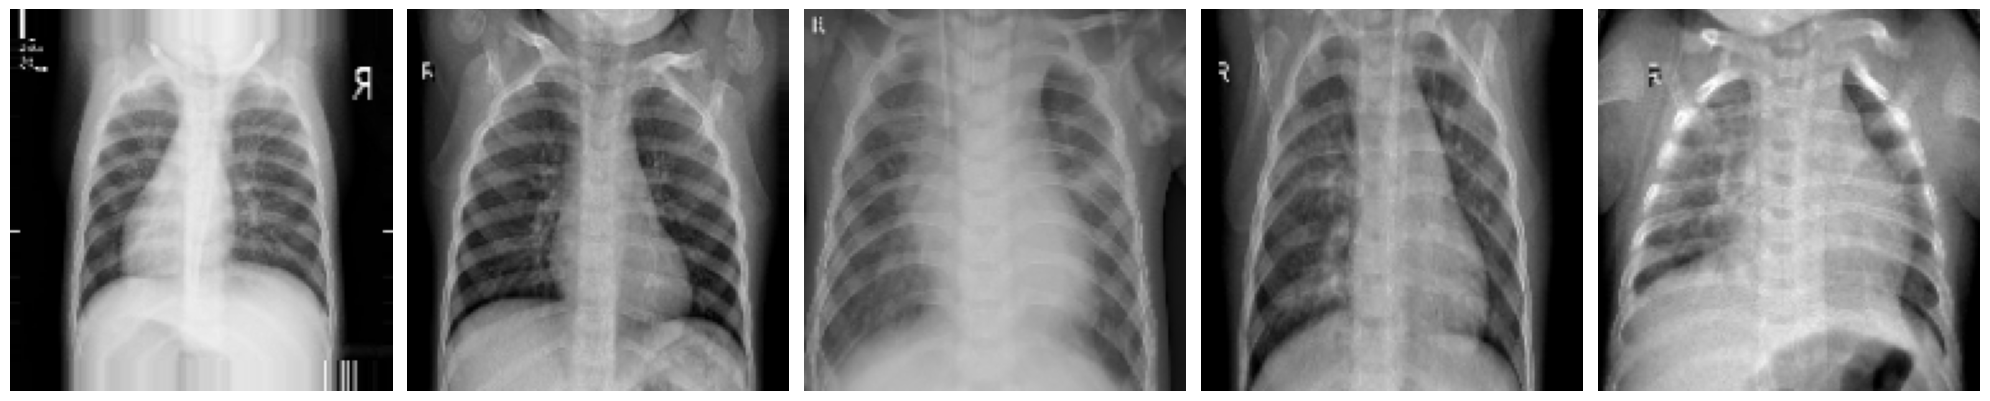

In [4]:
# Preview some images from the training data
sample_training_images, _ = next(train_generator)

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(sample_training_images[:5])

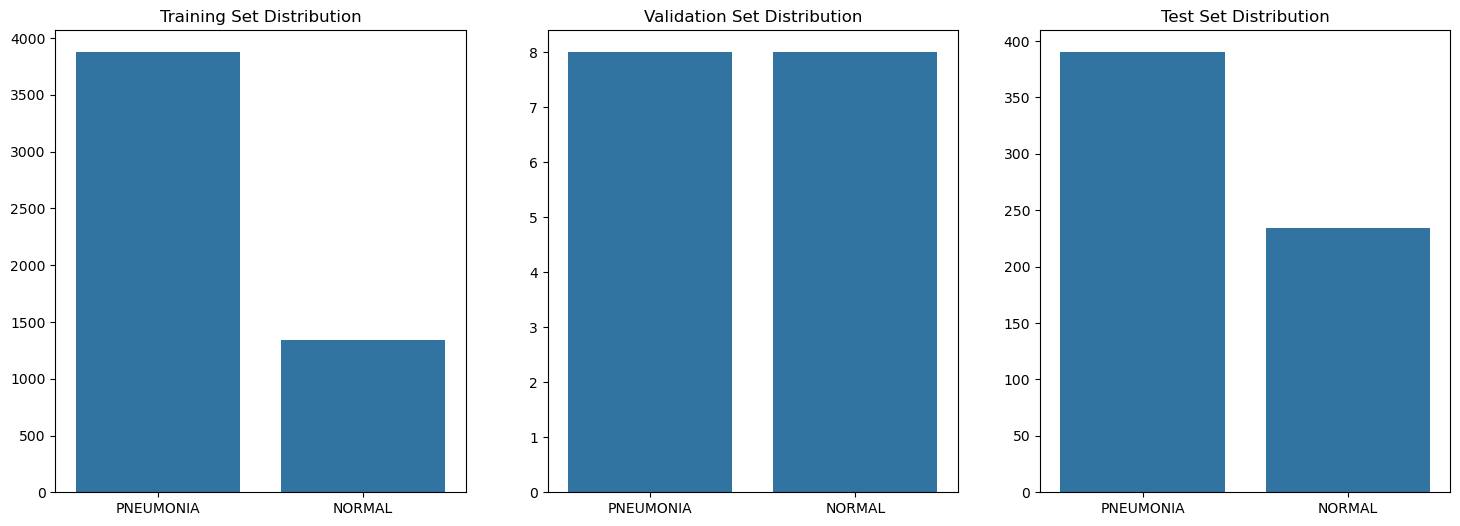

In [5]:
# Count the number of images in each class for training, validation, and test sets
def count_images(directory):
    categories = ['PNEUMONIA', 'NORMAL']
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Plotting the distribution
labels = ['PNEUMONIA', 'NORMAL']
train_values = [train_counts[label] for label in labels]
val_values = [val_counts[label] for label in labels]
test_values = [test_counts[label] for label in labels]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=labels, y=train_values, ax=ax[0]).set_title('Training Set Distribution')
sns.barplot(x=labels, y=val_values, ax=ax[1]).set_title('Validation Set Distribution')
sns.barplot(x=labels, y=test_values, ax=ax[2]).set_title('Test Set Distribution')
plt.show()


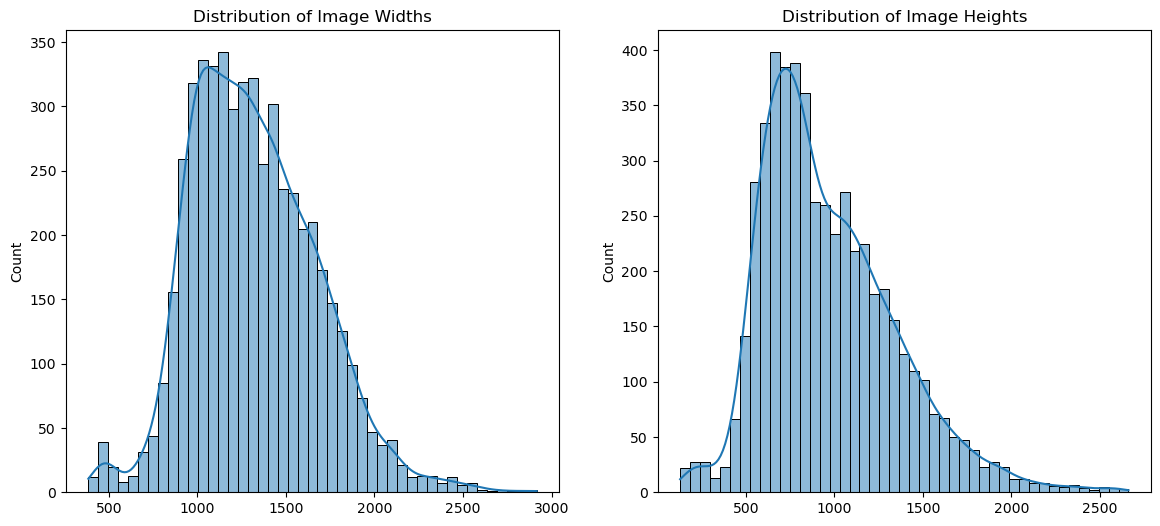

In [6]:
from PIL import Image

def analyze_image_dimensions(directory):
    heights = []
    widths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        for image_name in os.listdir(subdir_path):
            image_path = os.path.join(subdir_path, image_name)
            image = Image.open(image_path)
            widths.append(image.width)
            heights.append(image.height)
    return widths, heights

train_widths, train_heights = analyze_image_dimensions(train_dir)

# Plotting image dimensions distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(train_widths, kde=True, ax=ax[0]).set_title('Distribution of Image Widths')
sns.histplot(train_heights, kde=True, ax=ax[1]).set_title('Distribution of Image Heights')
plt.show()


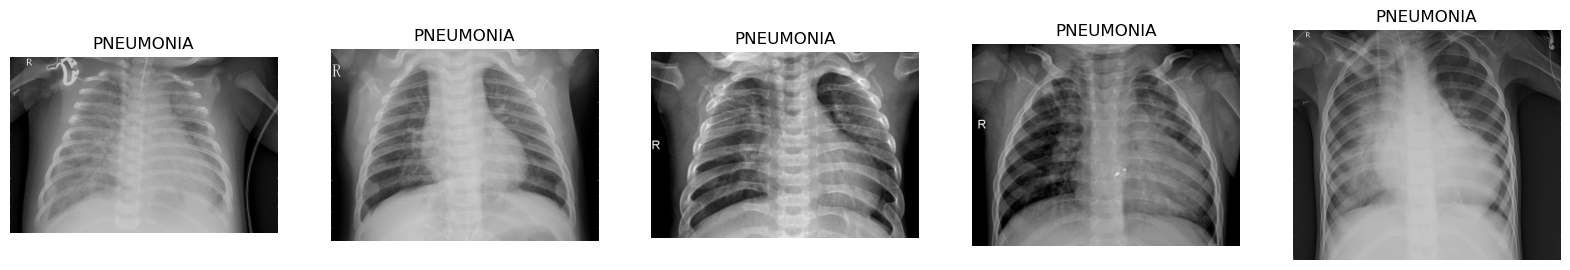

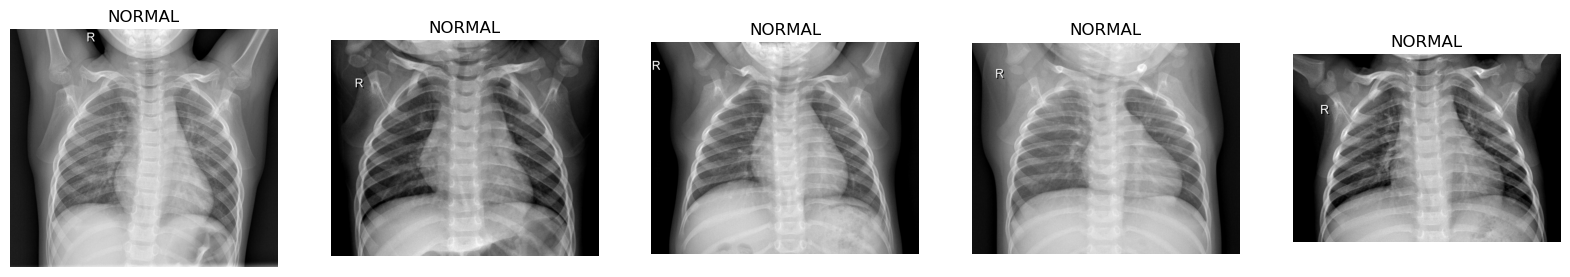

In [7]:
def display_samples(directory, category, num_samples=5):
    category_path = os.path.join(directory, category)
    sample_images = os.listdir(category_path)[:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for img, ax in zip(sample_images, axes):
        img_path = os.path.join(category_path, img)
        image = Image.open(img_path)
        ax.imshow(image, cmap='gray')
        ax.set_title(category)
        ax.axis('off')
    plt.show()

# Displaying samples from 'PNEUMONIA' and 'NORMAL' classes
display_samples(train_dir, 'PNEUMONIA')
display_samples(train_dir, 'NORMAL')


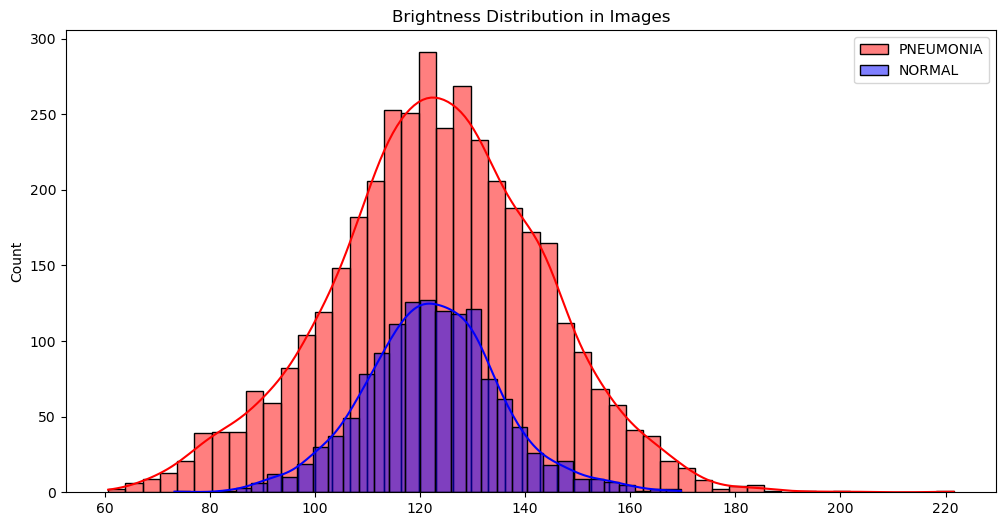

In [9]:
from PIL import ImageStat
def analyze_brightness(directory, category):
    brightness = []
    category_path = os.path.join(directory, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        stat = ImageStat.Stat(image)
        brightness.append(stat.mean[0])
    return brightness

pneumonia_brightness = analyze_brightness(train_dir, 'PNEUMONIA')
normal_brightness = analyze_brightness(train_dir, 'NORMAL')

# Plotting brightness distribution
plt.figure(figsize=(12, 6))
sns.histplot(pneumonia_brightness, color='red', label='PNEUMONIA', kde=True)
sns.histplot(normal_brightness, color='blue', label='NORMAL', kde=True)
plt.legend()
plt.title('Brightness Distribution in Images')
plt.show()


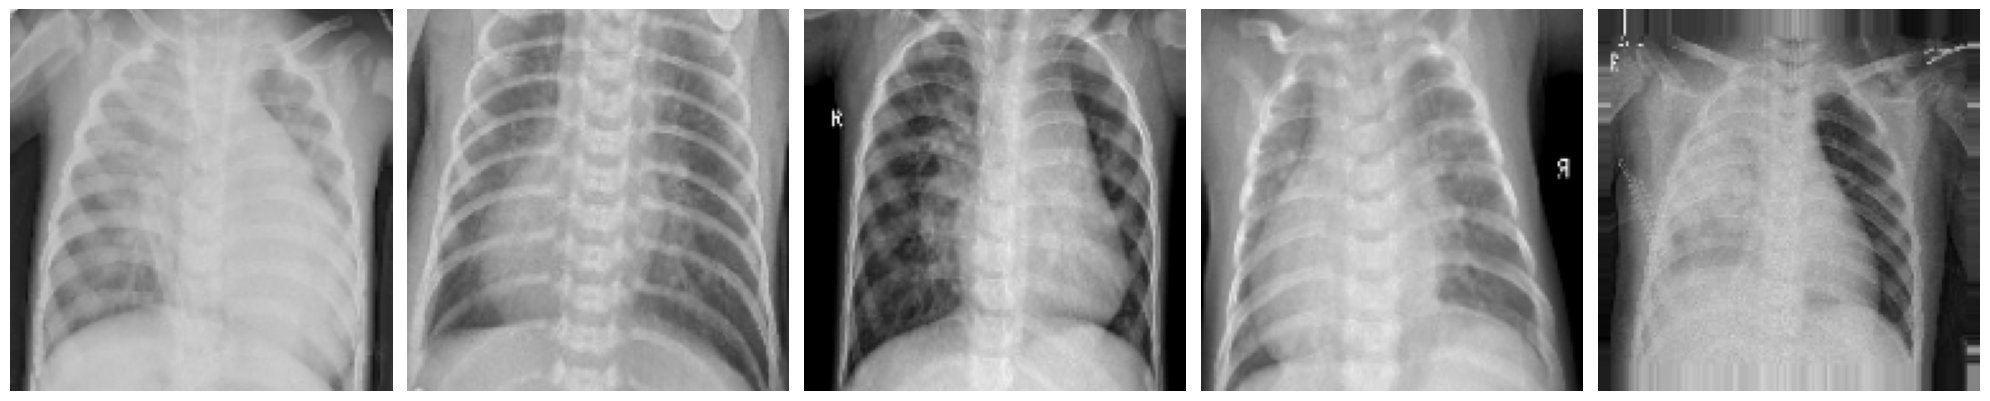

In [10]:
augmented_images, _ = next(train_generator)

# Visualize augmented images
plot_images(augmented_images[:5])


In [11]:
def check_corrupted_images(directory):
    corrupted_files = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        for img_name in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Check if image is corrupted
            except (IOError, SyntaxError) as e:
                corrupted_files.append(img_path)
    return corrupted_files

corrupted_files = check_corrupted_images(train_dir)
print("Corrupted files found:", len(corrupted_files))


Corrupted files found: 0


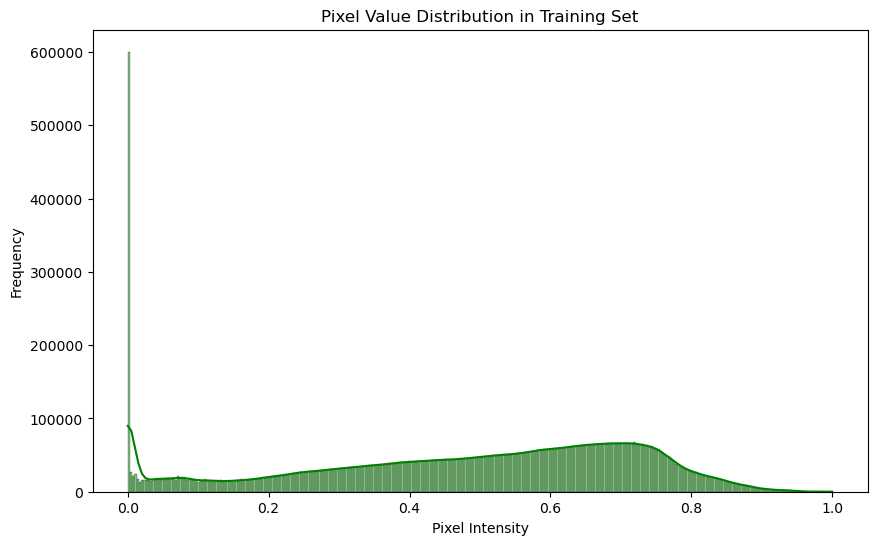

In [12]:
def analyze_pixel_distribution(generator, num_batches=5):
    pixel_values = []
    for i in range(num_batches):
        batch = next(generator)[0]
        pixel_values.extend(batch.ravel())
    return pixel_values

pixel_values_train = analyze_pixel_distribution(train_generator)

# Plotting pixel value distribution
plt.figure(figsize=(10, 6))
sns.histplot(pixel_values_train, kde=True, color='green')
plt.title('Pixel Value Distribution in Training Set')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


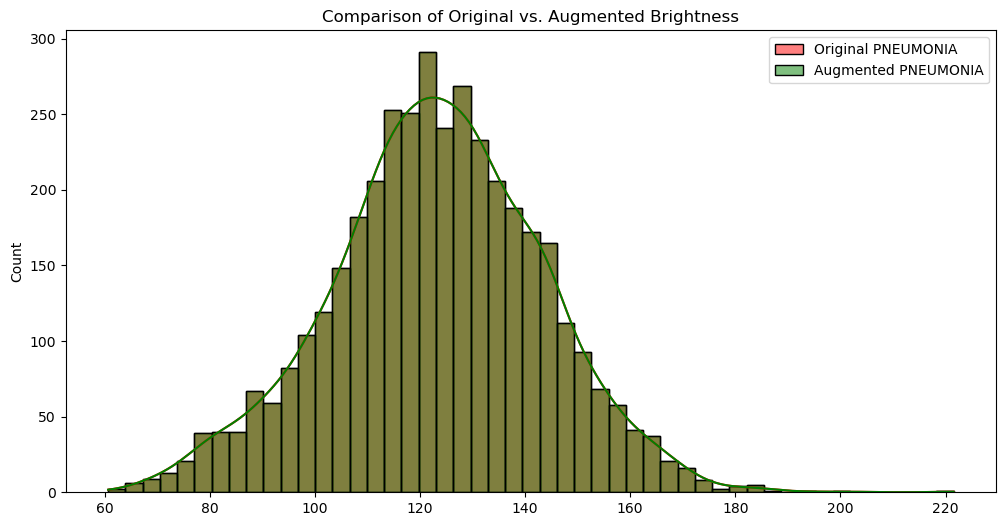

In [13]:
augmented_brightness = analyze_brightness(train_dir, 'PNEUMONIA')

# Plotting comparison of original vs. augmented image brightness
plt.figure(figsize=(12, 6))
sns.histplot(pneumonia_brightness, color='red', label='Original PNEUMONIA', kde=True)
sns.histplot(augmented_brightness, color='green', label='Augmented PNEUMONIA', kde=True)
plt.legend()
plt.title('Comparison of Original vs. Augmented Brightness')
plt.show()


In [14]:
def detect_outliers(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    return [x for x in data if (x < mean - threshold * std_dev) or (x > mean + threshold * std_dev)]

outliers_brightness = detect_outliers(pneumonia_brightness)
print("Number of brightness outliers in Pneumonia images:", len(outliers_brightness))


Number of brightness outliers in Pneumonia images: 10


Number of brightness outliers in PNEUMONIA images: 202
Number of brightness outliers in NORMAL images: 73


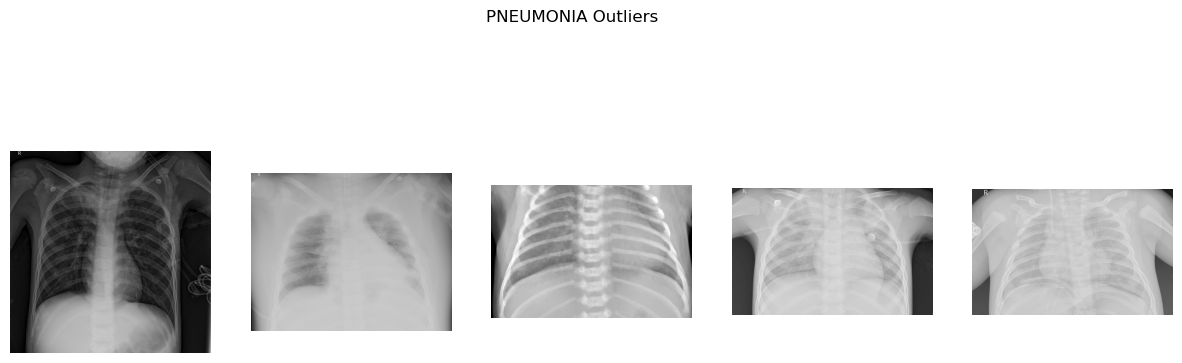

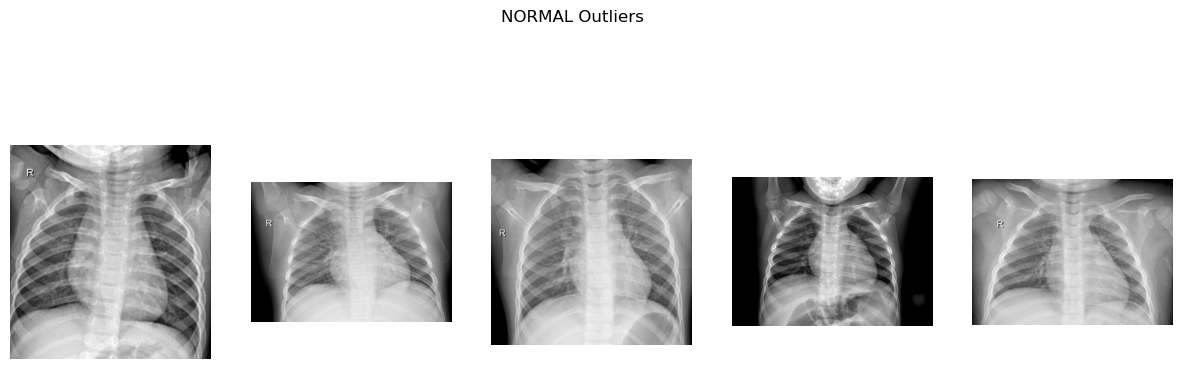

In [17]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to load images from a directory
def load_images_from_directory(directory, category):
    images = []
    category_path = os.path.join(directory, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        images.append(image)
    return images

# Load images
train_dir = 'diss_dataset/chest_xray/train/'  # Replace with the correct path
pneumonia_images = load_images_from_directory(train_dir, 'PNEUMONIA')
normal_images = load_images_from_directory(train_dir, 'NORMAL')

# Function to detect brightness outliers
def detect_brightness_outliers(images):
    brightness = [np.mean(np.array(img)) for img in images]
    mean_brightness = np.mean(brightness)
    std_brightness = np.std(brightness)
    
    outliers = [img for img, b in zip(images, brightness) if abs(b - mean_brightness) > 2 * std_brightness]
    return outliers

# Detect outliers
outliers_pneumonia = detect_brightness_outliers(pneumonia_images)
outliers_normal = detect_brightness_outliers(normal_images)

# Print the number of outliers
print(f'Number of brightness outliers in PNEUMONIA images: {len(outliers_pneumonia)}')
print(f'Number of brightness outliers in NORMAL images: {len(outliers_normal)}')

# Function to plot images
def plot_images(images, title=''):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(np.array(img), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize a few outliers
if outliers_pneumonia:
    plot_images(outliers_pneumonia[:5], title='PNEUMONIA Outliers')
if outliers_normal:
    plot_images(outliers_normal[:5], title='NORMAL Outliers')


# Preprocessing

In [18]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [19]:
# Rescaling and resizing are already handled in the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [22]:
#handling corrupted files
corrupted_files_train = check_corrupted_images(train_dir)
corrupted_files_val = check_corrupted_images(val_dir)
corrupted_files_test = check_corrupted_images(test_dir)

# Remove corrupted files if any are found
for corrupted_file in corrupted_files_train + corrupted_files_val + corrupted_files_test:
    os.remove(corrupted_file)
